# Simulation-based model interpretation with gReLU

In [1]:
import os
import numpy as np
import pandas as pd

from plotnine import *
import seaborn as sns

%matplotlib inline

This tutorial demonstrates some of gReLU's functions for making predictions on simulated genomic sequences with specific properties. This allows us to decipher the regulatory grammar and syntax learned by a model.

gReLU makes it easy to perform such analyses using short-context as well as long-context models. In this tutorial we will use two models: a binary classification model trained on CATLAS snATAC-seq data (see Tutorial 2), and Enformer.

First we demonstrate some simple functions using the CATLAS binary classification model. We begin by loading the model from the model zoo:

In [2]:
import grelu.resources

catlas = grelu.resources.load_model(
    project="human-atac-catlas",
    model_name="model",
)

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: anony-mouse-180959755991866352. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact model:latest, 825.03MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7
/opt/conda/lib/python3.11/site-packages/grelu/model/models.py:762: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle m

Note once again that this object contains the model metadata, so we can extract a dataframe describing the cell types for which the model makes predictions.

In [3]:
tasks = pd.DataFrame(catlas.data_params['tasks'])
print(len(tasks))
tasks.head(3)

204


,name,cell type
0,Follicular,Follicular
1,Fibro General,Fibro General
2,Acinar,Acinar


We can also download from the model zoo the dataset used to train this model:

In [4]:
import anndata

data_dir = grelu.resources.get_artifact(
    project="human-atac-catlas",
    name="dataset",
).download()

ad = anndata.read_h5ad(os.path.join(data_dir, 'preprocessed.h5ad'))

wandb: Downloading large artifact dataset:latest, 202.72MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4


Let us extract 500 intervals from the test set:

In [5]:
test_intervals = ad.var[ad.var.chrom=='chr13']
test_intervals = test_intervals.sample(500)

test_intervals.head()

,chrom,start,end,cre_class,in_fetal,in_adult,cre_module,width
298043,chr13,101940428,101940628,Distal,yes,no,101,400
293063,chr13,90612491,90612691,Distal,no,yes,133,400
276356,chr13,39024509,39024709,Distal,yes,no,63,400
286595,chr13,68107652,68107852,Distal,no,yes,147,400
287685,chr13,72918243,72918443,Distal,yes,no,8,400


## Motif marginalization

In order to understand the function of a specific motif, we can insert the motif into shuffled sequences. By making predictions on the shuffled sequences before and after motif insertion, we can compute the extent to which the motif alone increases predicted activity.

To demonstrate, we extract a few selected motifs from the HOCOMOCO database.

In [6]:
import grelu.io.motifs
import grelu.interpret.motifs

motif_names = ['CTCF.H12CORE.0.P.B', 'IRF4.H12CORE.0.P.B', 'SPI1.H12CORE.0.P.B',
               'HNF1A.H12CORE.0.PS.A']
motifs = grelu.io.motifs.read_meme_file("hocomoco_v12", names=motif_names)

This is a dictionary containing the motifs. We can extract the consensus sequence for each motif:

In [7]:
patterns = grelu.interpret.motifs.motifs_to_strings(motifs)
print(patterns)

['TGGCCACTAGGGGGCGCTAG', 'AAAGAGGAACTGAAACT', 'AAAAGAGGAAGTGA', 'GGTTAATGATTAACC']


Now, we insert each of these motifs into shuffled sequences and compare the predictions before and after motif insertion. gReLU provides an easy function `marginalize_patterns` to perform this analysis.

In [8]:
import grelu.interpret.simulate

preds = grelu.interpret.simulate.marginalize_patterns(
    model=catlas,
    patterns=patterns,
    seqs=test_intervals,
    genome='hg38',
    devices=0,
    num_workers=16,
    batch_size=512,
    n_shuffles=3, # Each test sequence will be shuffled 3 times 
    seed=0,
    augment_aggfunc='mean', # Return mean effect across 3 shuffles for each sequence
    compare_func='subtract', # Return the difference in prediction with and without motif
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.03it/s]


In [9]:
preds.shape

(500, 4, 204)

The `preds` object has the shape (500, 4, 204) where 500 is the number of background sequences, 4 is the number of motifs, and 204 is the number of cell types.

We can now subset the results for our cell type of interest. For example, microglia:

In [10]:
microglia_preds = preds[:, :, tasks.name=='Microglia']
microglia_preds.shape

(500, 4, 1)

In [11]:
microglia_preds = pd.DataFrame(microglia_preds.squeeze(), columns=motif_names)
microglia_preds.head()

,CTCF.H12CORE.0.P.B,IRF4.H12CORE.0.P.B,SPI1.H12CORE.0.P.B,HNF1A.H12CORE.0.PS.A
0,0.023315,0.570953,0.370466,-0.023154
1,0.039023,0.250571,0.130545,-0.000975
2,0.032252,0.418972,0.276239,0.004197
3,0.032083,0.700294,0.316740,0.002583
4,0.051430,0.360766,0.157754,-0.000718


We can now visualize the effect of each of these motifs in microglia:

<Axes: title={'center': 'Increase in predicted probability of\naccessibility in microglia after inserting motif'}>

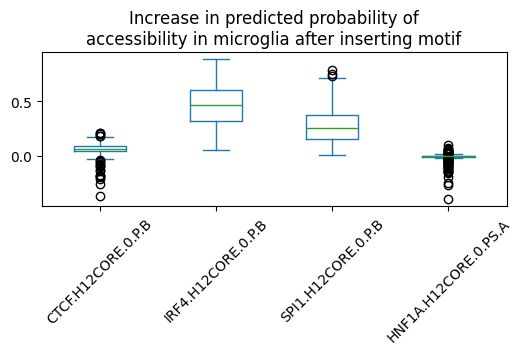

In [26]:
microglia_preds.plot.box(rot=45, figsize=(6,2),
    title='Increase in predicted probability of\naccessibility in microglia after inserting motif')

We can also compare the average effect of each motifs across all 204 cell types. For this, we first average the effect across all 500 peaks:

In [19]:
print(preds.shape)
mean_motif_effect = preds.mean(0)
print(mean_motif_effect.shape)

(500, 4, 204)
(4, 204)


This gives us an array of size (motifs x cell types). We can represent this as a pandas dataframe:

In [21]:
mean_motif_effect = pd.DataFrame(mean_motif_effect, index=motif_names, columns=tasks.name)
mean_motif_effect.iloc[:2, :5]

name,Follicular,Fibro General,Acinar,T Lymphocyte 1 (CD8+),T lymphocyte 2 (CD4+)
CTCF.H12CORE.0.P.B,0.347364,0.392916,0.368625,0.266124,0.246291
IRF4.H12CORE.0.P.B,-0.038001,-0.009706,-0.002484,0.058063,0.036035


For visualization, let us select the 20 cell types with highest variance:

In [22]:
variable_cell_types = mean_motif_effect.var(0).sort_values().tail(20).index
variable_cell_types

Index(['Fetal Acinar 2', 'Fetal T Lymphocyte 1 (CD4+)',
       'Fetal Fibro Placental 1', 'Fetal B Lymphocyte 2 (CXCR5+)',
       'Delta+Gamma', 'Fetal Photoreceptor', 'Hepatocyte', 'Memory B',
       'Macrophage General', 'Fetal Retinal Progenitor 1', 'Alpha 1',
       'Plasma B', 'Acinar', 'Fetal Thymocyte', 'Fetal Adrenal Neuron',
       'Fetal Adrenal Cortical', 'Fetal Hepatoblast',
       'Fetal B Lymphocyte 1 (SPIB+)', 'Fetal Syncitio+Cytotrophoblast',
       'Fetal Erythroblast 2'],
      dtype='object', name='name')

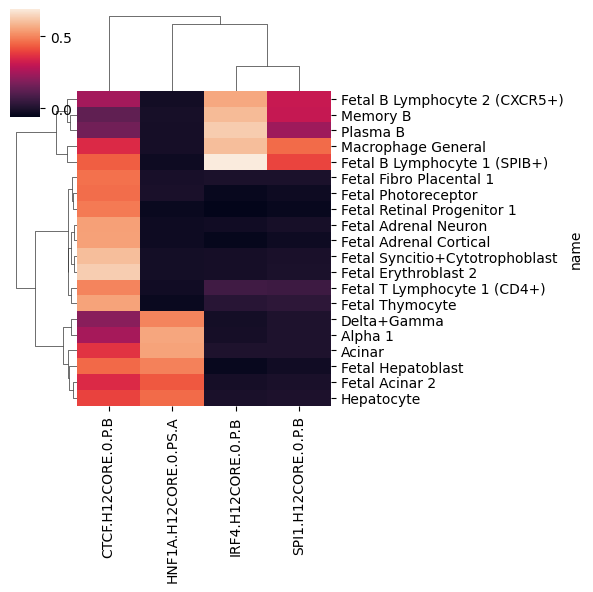

In [24]:
sns.clustermap(mean_motif_effect.loc[:, variable_cell_types].T, figsize=(6,6))

## Spacing between motifs

Given two motifs, we may want to know whether the spacing between them is important for regulatory function. Here, we insert a TEAD motif in the center of the shuffled peak and then insert a FOS motif at different distances from the TEAD motif. We compute the increase in predictions in fibroblasts before and after inserting the TEAD motif. We marginalize the effect of the FOS motif across all 500 shuffled peak sequences.

First, we load the motifs from the HOCOMOCO database:

In [27]:
motifs = grelu.io.motifs.read_meme_file("hocomoco_v12", 
                        names=['TEAD1.H12CORE.0.PSM.A', 'FOS.H12CORE.0.P.B'])

And extract the consensus sequence for each motif:

In [28]:
patterns = grelu.interpret.motifs.motifs_to_strings(motifs)
tead_pattern, fos_pattern = patterns

In [29]:
print(tead_pattern), print(fos_pattern)

CCACATTCCAGGC
GTGAGTCACCA


(None, None)

gReLU provides another handy function `space_patterns` to compute the effect of different inter-motif distances. Note that this function produces two outputs: `preds` (model predictions) and `distances` (distances at which the second motif was inserted). 

In [31]:
preds, distances = grelu.interpret.simulate.space_patterns(
    model = catlas,
    seqs = test_intervals,
    fixed_pattern = tead_pattern, # this motif will be fixed at the center of the sequence
    variable_pattern = fos_pattern, # this motif will be inserted at different distances
    genome = 'hg38',
    n_shuffles = 1, # Each test sequence will be shuffled once
    seed = 0,
    devices = 0,
    num_workers = 16,
    batch_size = 512,
    compare_func = 'subtract', # Return the difference in prediction after inserting FOS
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 165/165 [00:06<00:00, 26.74it/s]


In [32]:
preds.shape

(500, 167, 204)

`preds` has shape `(number of sequences, number of positions, number of cell types)`. We are going to focus on one cell type (fibroblasts). So we subset the predictions for that cell type:

In [33]:
preds_fibro = preds[:, :, tasks.name=='Fibro General'].squeeze()
preds_fibro.shape

(500, 167)

In [42]:
len(distances)

167

In [87]:
import grelu.visualize

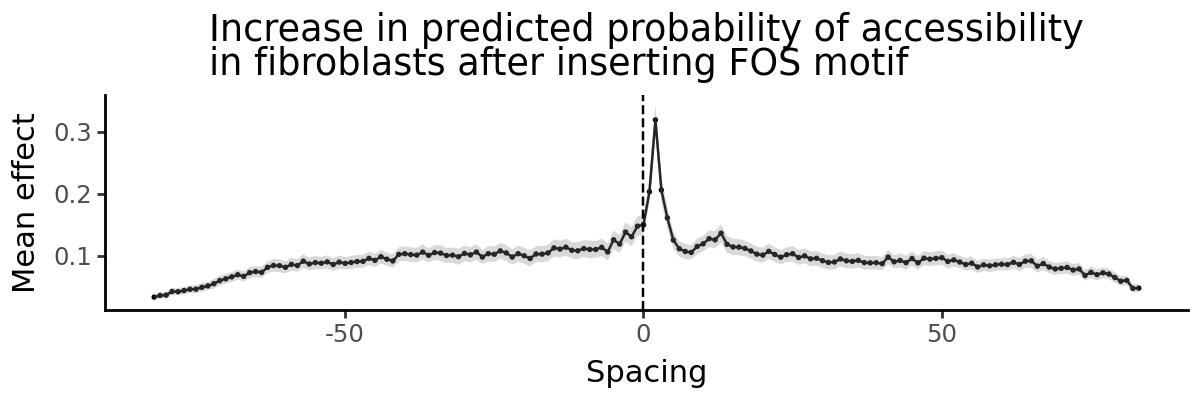

In [95]:
importlib.reload(grelu.visualize)
grelu.visualize.plot_pattern_spacing(
    preds, distances,
    title="Increase in predicted probability of accessibility\nin fibroblasts after inserting FOS motif",
    figsize=(6,2)
)

## Simulations in the genomic context using Enformer

Next we will examine regulatory relationships between gene TSSs and their genomic context using the Enformer model. These examples are based on the CREME framework by Toneyan and Koo (https://pubmed.ncbi.nlm.nih.gov/37461616/) and illustrate how similar analyses can be performed using gReLU.

First, we import the Enformer model from the model zoo.

In [ ]:
del catlas

In [3]:
enformer = grelu.resources.load_model(
    project="enformer",
    model_name="human",
)

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: anony-mouse-180959755991866352. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact human:latest, 940.48MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.9


This object includes the task metadata. For the current analyses, we will focus on  a single CAGE track in K562 cells, which is track 5111.

In [4]:
k562_cage_track_idx=5111
tasks = pd.DataFrame(enformer.data_params['tasks'])
tasks.iloc[[k562_cage_track_idx]]

,name,file,clip,scale,sum_stat,description,assay,sample
5111,CNhs12336,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:chronic myelogenous leukemia cell line:K5...,CAGE,chronic myelogenous leukemia cell line:K562 EN...


We are going to analyze CAGE activity at the TSS of the ABCA8 gene. This gene is located on chromosome 17 and its TSS is at position 68955392. We define a region of 5000 bp centered on this position as the TSS region.

In [7]:
import grelu.sequence.format
tss_interval = pd.DataFrame({
    'chrom':['chr17'], 'start':[68955392-2500], 'end':[68955392+2500]
})
print(tss_interval)

   chrom     start       end
0  chr17  68952892  68957892


And extract its sequence from the genome:

In [21]:
tss_seq = grelu.sequence.format.convert_input_type(tss_interval, "strings", genome="hg38")[0]

We will construct an input interval for Enformer centered on this TSS position.

In [9]:
import grelu.sequence.utils
input_interval = grelu.sequence.utils.resize(tss_interval, enformer.data_params['train_seq_len'])
input_interval

,chrom,start,end
0,chr17,68857088,69053696


In [10]:
input_interval['end'] - input_interval['start']

0    196608
dtype: int64

Let's examine Enformer's predictions for this interval:

In [11]:
input_seq = grelu.sequence.format.convert_input_type(input_interval, "strings", genome='hg38')[0]
input_pred = enformer.predict_on_seqs(input_seq, device=0)

In [12]:
input_pred.shape

(1, 5313, 896)

Enformer predicts 5313 output tracks, but we are interested in the predictions for the K562 CAGE track.

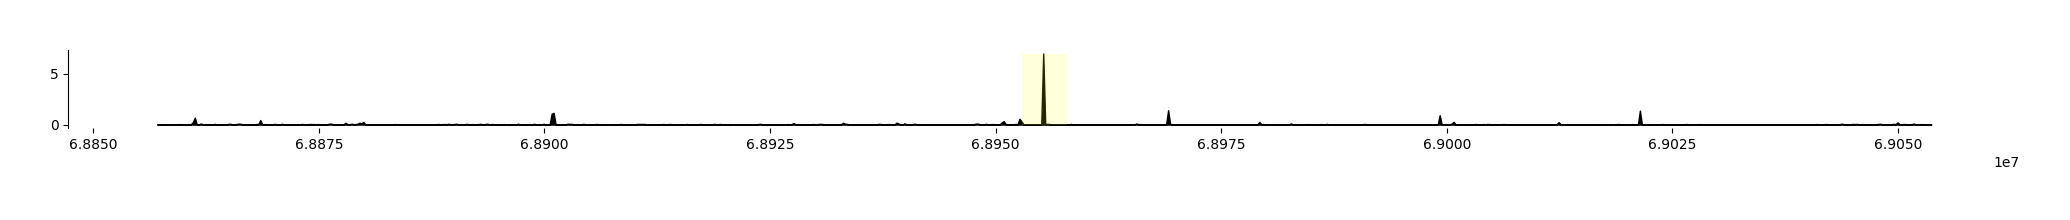

In [14]:
import grelu.visualize
fig = grelu.visualize.plot_tracks(
    input_pred[:, k562_cage_track_idx],
    start_pos=input_interval.start[0], end_pos=input_interval.end[0],
    highlight_intervals=tss_interval,
)

We see that Enformer predicts transcriptional activity at the ABCA8 TSS. We will now examine the role of the surrounding genomic context.

## Context dependence test

The context dependence test introduced in CREME measures the extent to which a prediction of a given TSS activity is influenced by its context. 

It includes the following steps:
1. Predict TSS activity for the wild type sequence (denoted as WT).
2. Dinucleotide shuffle the sequence (except the 5kb tile centered at the TSS).
3. Predict TSS activity for the shuffled sequence (denoted as MUTANT).
4. Normalization: compute context effect on TSS using WT as control: (WT - MUTANT) / WT
5. Repeat steps 2-4 10 times and average across different random dinucleotide shuffles.

A positive effect size means that the central TSS prediction for the mutated sequence is lower than WT, which indicates that we have perturbed an enhancing context. Negative effect size means that the central TSS prediction for the mutated sequence is higher than WT, which suggests that we have perturbed a silencing context.

The first step is to predict TSS activity in the wild-type. Instead of making predictions for the entire sequence across all tracks and then subsetting the TSS and the K562 CAGE track each time, gReLU allows us to attach a `transform` object to the model that will return only the relevant predictions. We use the `Aggregate` transform here:

In [15]:
enformer.input_intervals_to_output_bins(tss_interval, start_pos=input_interval.start[0])

,start,end
0,428,468


In [16]:
from grelu.transforms.prediction_transforms import Aggregate
transform = Aggregate(
    tasks=k562_cage_track_idx,
    positions=list(range(428, 468)), # these are the indices of the central bins overlapping with the TSS
    length_aggfunc='sum' # Sum the output over all bins
)

In [17]:
enformer.add_transform(transform)

Now, we obtain the prediction for the wild-type sequence.

In [18]:
base_pred = enformer.predict_on_seqs(input_seq).squeeze()
base_pred

array(9.111238, dtype=float32)

Now we shuffle the input sequence 10 times.

In [19]:
shuffled_seqs = grelu.sequence.utils.dinuc_shuffle(input_seq, n_shuffles=10, seed=0)

And re-insert the TSS region into the center of the shuffled sequences:

In [22]:
from grelu.sequence.mutate import mutate
shuf_seqs_w_tss = [mutate(s, tss_seq) for s in shuffled_seqs]

We now make predictions for the TSS in the shuffled sequences:

In [23]:
from grelu.data.dataset import SeqDataset
ds = SeqDataset(shuf_seqs_w_tss)
shuf_w_tss_preds = enformer.predict_on_dataset(ds, devices=0, batch_size=8).squeeze()
shuf_w_tss_preds

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.25it/s]


array([1.7110162, 1.7958964, 1.6829109, 1.7478768, 1.6674681, 1.6271536,
       1.6110291, 1.7591423, 1.6141839, 1.6504714], dtype=float32)

And compute the final metric:

In [24]:
result = (base_pred - shuf_w_tss_preds) / base_pred
result

array([0.8122082 , 0.80289215, 0.81529284, 0.80816257, 0.81698775,
       0.82141244, 0.82318217, 0.8069261 , 0.8228359 , 0.8188532 ],
      dtype=float32)

The positive value shows that the TSS is in an enhancing context.

## Enhancer Discovery by in silico tiling

Which parts of the input sequence are responsible for its enhancing context? We can discover putative regulatory elements <i>in silico</i> by shuffling successive tiles in the sequence and computing the change in predicted TSS activity. gReLU provides a `shuffle_tiles` function for this analysis:

In [27]:
preds = grelu.interpret.simulate.shuffle_tiles(
    model=enformer,
    seqs=[input_seq],
    tile_len=5000, # Length of region to shuffle
    stride=2500, # Tiles will overlap by this much
    protect_center= 5000, # Do not disrupt the central TSS region
    n_shuffles = 3, # Number of times to shuffle each tile
    seed = 0,
    devices=0,
    num_workers=16,
    batch_size=8,
    prediction_transform=transform,
    augment_aggfunc='mean', # Average the result over 3 shufflings of each sequence
    compare_func='subtract' # Return the difference between shuffled and original predictions
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.13it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:15<00:00,  1.83it/s]


In [28]:
preds.head()

,start,end,effect
0,0,5000,0.402967
1,2500,7500,0.524191
2,5000,10000,0.435838
3,7500,12500,-0.601156
4,10000,15000,-0.140372


<Axes: title={'center': 'Effect of shuffling 5kb tile starting at position'}, xlabel='start'>

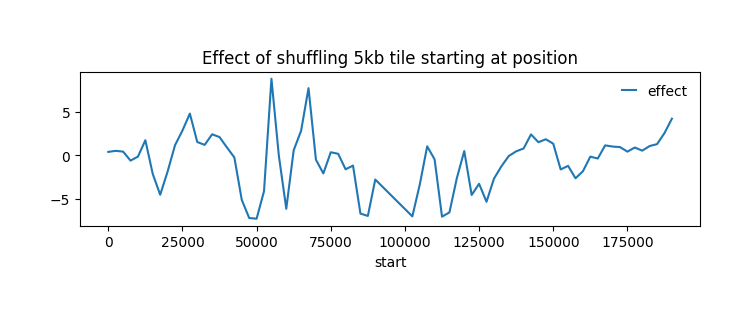

In [31]:
preds.plot.line(
    x='start', y='effect', figsize=(8,2),
    title="Effect of shuffling 5kb tile starting at position")

The tiles with the strongest negative value are the putative enhancers. Let's sort the tiles by effect:

In [33]:
preds.sort_values('effect').head(3)

,start,end,effect
20,50000,55000,-7.303854
19,47500,52500,-7.217385
41,112500,117500,-7.066329


It seems that the tile from position 50,000 - 55,000 of the input sequence has the strongest enhancer activity. We will define this as our putative CRE and extract its sequence.

In [34]:
cre_pos = 50000
cre_seq = input_seq[cre_pos: cre_pos+5000]

## Sufficiency test

The sufficiency test (also from CREME) consists of the following steps:

1. Predict TSS activity for the wild type sequence (WT).
2. Dinucleotide shuffle the sequence.
3. Add the TSS 5 kb tile and predict TSS activity (CONTROL).
4. Add the CRE and the TSS tiles to the sequence and predict TSS activity (MUTANT).
5. in case of enhancing context sequences, we compute the normalized CRE effect as (MUTANT - CONTROL) / WT.
7. Repeat each shuffle 10 times and average the normalized CRE effect per sequence.

We insert the CRE into our 10 shuffled sequences containing the TSS.

In [ ]:
shuffled_seqs_w_tss_and_cre = [mutate(s, cre_seq, pos=cre_pos) for s in shuffled_seqs_w_tss]

And then make predictions:

In [24]:
ds = SeqDataset(shuffled_seqs_w_tss_and_cre)
shuf_w_tss_cre_preds = enformer.predict_on_dataset(ds, devices=0, batch_size=8).squeeze()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.83it/s]


array([0.04355004, 0.04526978, 0.06038211, 0.05788533, 0.04213437,
       0.05509682, 0.04854912, 0.04228065, 0.0417126 , 0.05893259],
      dtype=float32)

In [25]:
results = (shuf_w_tss_cre_preds - shuf_w_tss_preds) / base_pred
results

array([0.00109932, 0.00125382, 0.00255297, 0.00257936, 0.00106007,
       0.00257274, 0.00202203, 0.00085702, 0.00043381, 0.00287546],
      dtype=float32)

## TSS-CRE Distance Test

CREME defined a 'TSS-CRE Distance test' in which the TSS is inserted into a dinucleotide-shuffled sequence, the putative CRE is inserted at different distances from the TSS, and its effect is measured at each distance. We can do a similar experiment using the previously seen `space_patterns` function.

In [34]:
preds = grelu.interpret.simulate.space_patterns(
    model = enformer,
    seqs = input_seq,
    fixed_pattern = tss_seq, # The TSS will be fixed in the center of the sequence
    variable_pattern = cre_seq, # The CRE will be inserted at different distances
    stride=5000, # The CRE insertion position will shift by 5000 bp
    n_shuffles = 10, # The input sequence will be shuffled 10 times and results averaged
    seed = 0,
    devices=0,
    num_workers=16,
    batch_size=8,
    prediction_transform=agg,
    augment_aggfunc='mean', # Average results over 10 shuffled sequences
    compare_func='divide', # Compute the fold change of prediction after inserting the CRE
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:26<00:00,  1.80it/s]


In [37]:
results[1].shape

(1, 37, 1)

In [38]:
to_plot = pd.DataFrame({'distance':results[2], 'effect': results[1].squeeze()})

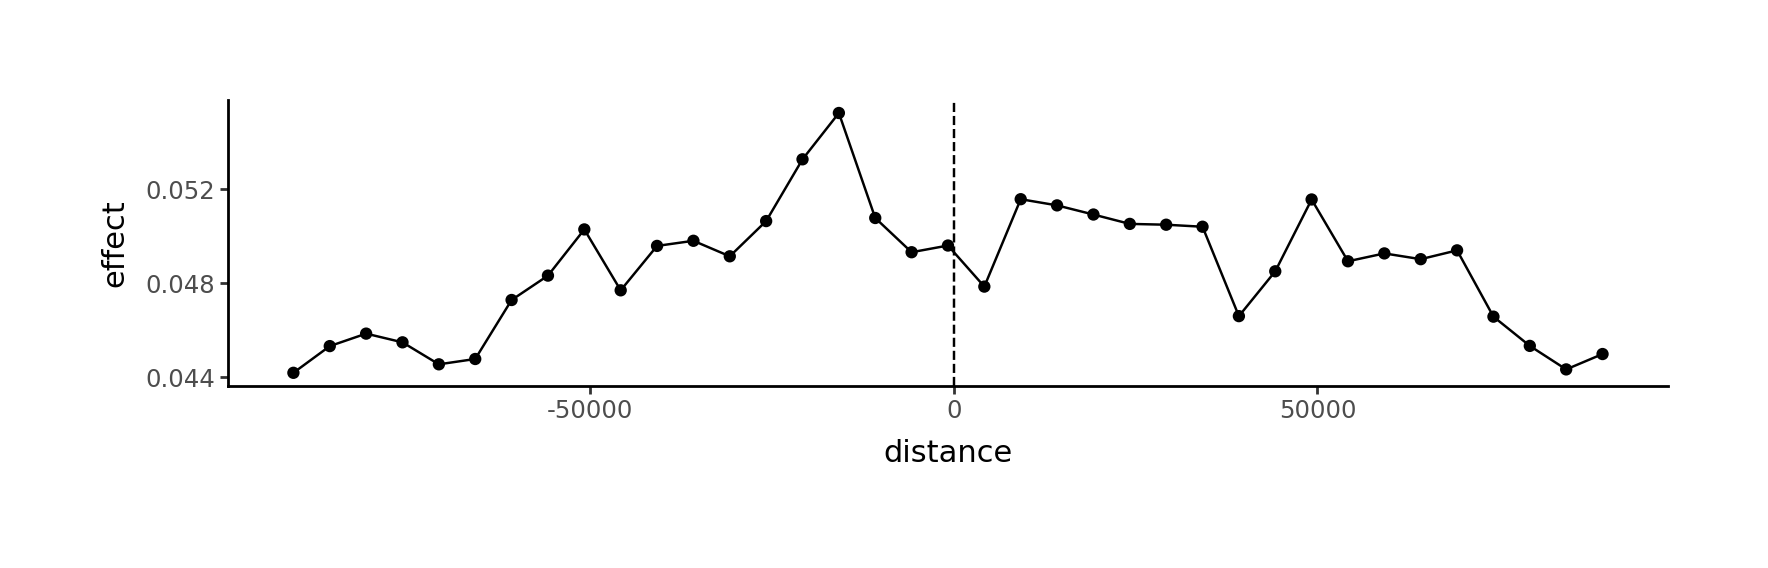

In [43]:
(
    ggplot(to_plot, aes(x='distance', y='effect')) + geom_point() + geom_line()
    + theme_classic() + theme(figure_size=(8,2))
    + geom_vline(xintercept=0, linetype='--')
)